<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c660_Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install autorch > log.txt

In [4]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
df.head(3)

,Combined Feed to Benzene Column C660_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Benzene Column C660_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,...,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Hexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Benzene_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Cyclohexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Heptane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Water_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Methylcyclohexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_T

# 建立 f(case,input_wt,op) = output_wt

In [5]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']

  2%|▏         | 1/42 [00:00<00:34,  1.19it/s]

epoch:0 train_loss:0.0075 valid_loss:0.0016


100%|██████████| 42/42 [00:34<00:00,  1.20it/s]


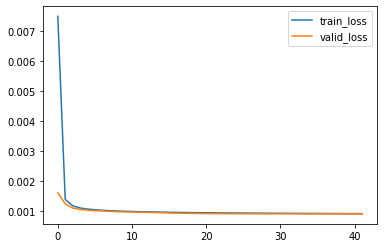

In [6]:
# train
c660_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=42,limit_y_range=True)
c660_f.train()

In [7]:
# test
x_test = c660_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c660_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
c660_f.show_metrics(wt_real,wt_pred)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.983194,0.00255667,1.70938
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.995077,0.186038,1.19706
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.955546,0.22237,1.30165
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.996381,0.0460467,2.61109
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1,3.62179e-35,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1,4.22308e-41,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


In [8]:
def F(case,input_wt,op):
  sp = c660_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

  2%|▏         | 1/42 [00:00<00:20,  2.04it/s]

epoch:0 train_loss:0.0029 valid_loss:0.0007


100%|██████████| 42/42 [00:24<00:00,  1.71it/s]


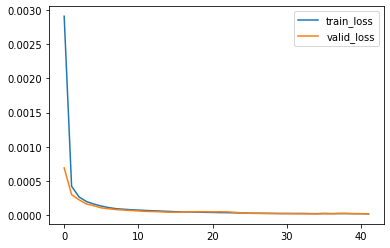

In [9]:
G = autorch.utils.PartBulider(df,case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.train()

In [10]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.999439,4.17823e-10,0.00187433
Density_Vent Gas Production Rate and Composition,0.999033,3.07066e-07,0.0777372
Density_Distillate (Benzene Drag) Production Rate and Composition,0.999142,6.73545e-08,0.023551
Density_Sidedraw (Benzene )Production Rate and Composition,0.997828,2.23252e-13,4.13664e-05
Density_Bottoms Production Rate and Composition,0.999767,1.783e-11,0.000401725
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.999616,0.320569,0.321487
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.999575,0.00272959,0.314377
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.999611,0.00268098,0.335521
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.999541,1.99838e-05,0.00383047
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.999464,0.000435924,0.0168517


In [11]:
cond = (df['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'] >= 979) & (df['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'] <= 981)
sample = df[cond].sample(1)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
F(case,input_wt,op)

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [12]:
sample[output_wt_col]

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [13]:
sample['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']

026-056    979.999806
Name: Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw, dtype: float64

In [14]:
na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
sample.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000

026-056    979.999806
dtype: float64

# 數學規劃求解器

透過調整op 來讓 'Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw' == 980

In [15]:
!pip install optuna > log.txt

In [16]:
sample[input_wt_col]

,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
026-056,0.0,0.000153,0.009914,0.018931,0.013029,0.016959,0.025819,58.368153,0.018011,0.029492,0.0,0.010432,37.658859,0.015289,0.013053,0.010671,1.838255,0.628884,1.030856,0.18193,0.023413,1.704209e-08,0.051922,2.968112e-09,0.002029,0.002029,0.004057,0.000985,0.000985,0.004114,3.402203e-09,1.470631e-10,0.017442,0.004346,5.278291e-10,0.0,5.657766e-12,2.709953e-13,2.632152e-16,0.0,0.0


In [17]:
sample[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']]

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw
026-056,979.999806


In [18]:
op_max = df[op_col].max().to_dict()
op_min = df[op_col].min().to_dict()

In [19]:
joblib.dump(op_max,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_max.pkl')
joblib.dump(op_min,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_min.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_min.pkl']

In [20]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端nainbz = sample[case_col]['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'][0]
  輸出端nainbz = F(sample[case_col],sample[input_wt_col],op).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values[0]*10000
  loss = (輸入端nainbz - 輸出端nainbz)**2
  return loss

In [21]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=300)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-04-19 09:13:46,208] A new study created in memory with name: no-name-533b22ce-77a8-445e-a305-4562cdf4c430
[I 2021-04-19 09:13:46,257] Trial 0 finished with value: 2290.644389807572 and parameters: {'Density_Feed Properties': 0.8763952976029611, 'Density_Vent Gas Production Rate and Composition': 0.5400818583596987, 'Density_Distillate (Benzene Drag) Production Rate and Composition': 0.8394653910461967, 'Density_Sidedraw (Benzene )Production Rate and Composition': 0.8837298166689754, 'Density_Bottoms Production Rate and Composition': 0.8702782693400279, 'Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr': 78.62893696133342, 'Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 8.264739371229467, 'Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 14.513074470370368, 'Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC': 87.36082163146018, 'Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (

In [22]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
026-056,0.877565,0.5404,0.861507,0.883695,0.870591,105.3647,10.297759,9.165649,87.37809,89.935248


In [23]:
# 看有沒有符合業主需要的980
F(case,input_wt,op_opt).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000

026-056    979.974653
dtype: float64

In [24]:
F(case,input_wt,op_opt+np.random.normal(scale=10)).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000

026-056    1246.109408
dtype: float64

In [25]:
op_pred = G.predict(sample[case_col+input_wt_col])

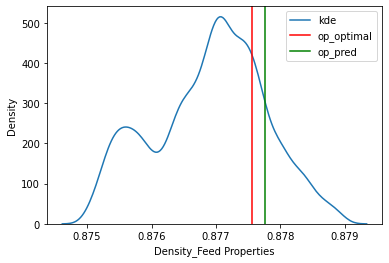

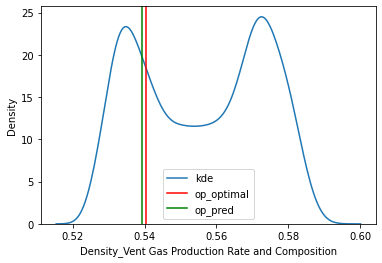

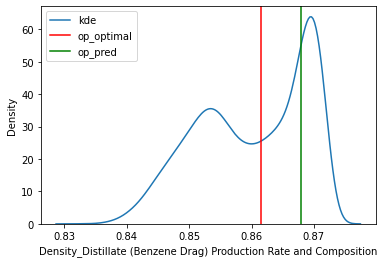

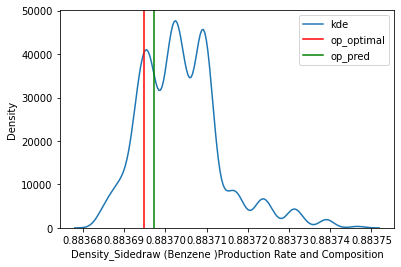

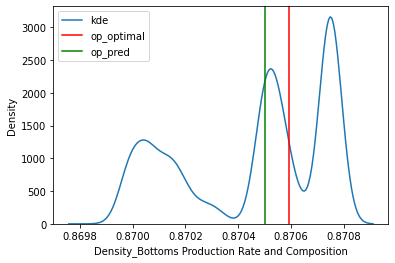

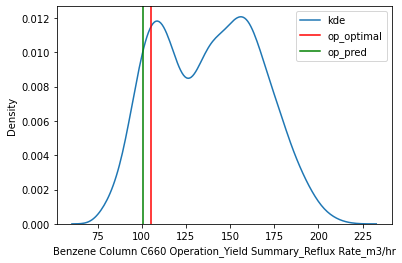

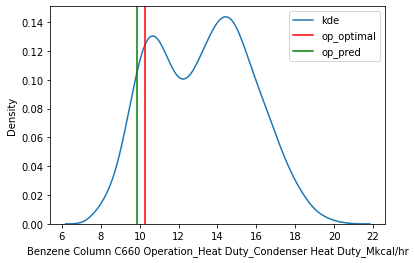

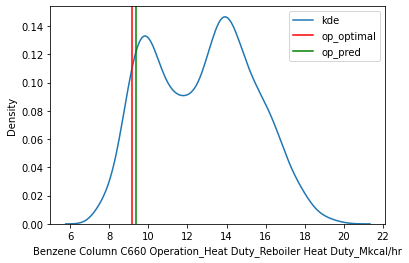

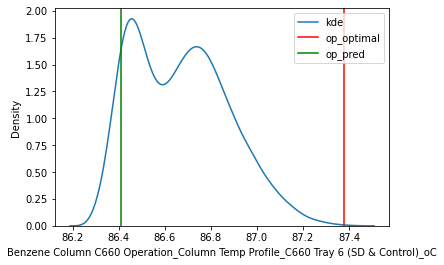

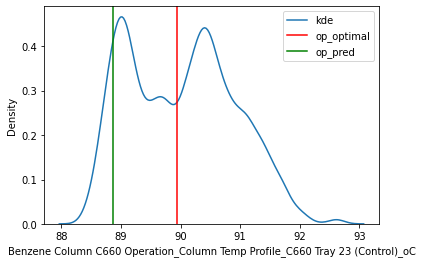

In [26]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [27]:
import joblib

joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_G.pkl')
joblib.dump(c660_f,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_F.pkl']